In [1]:
import json
from typing import List, Union
from pathlib import Path
import re

import pandas as pd
import requests
import yaml

In [2]:
CONFIG_FILENAME = "config_gtfs.yaml"

In [3]:
#supressão de serviço tipo SN
#Tipo de serviço é o 8 character do id de rotas.
er=[]
def is_not_SN(route_id):
    #print(route_id,route_id[7],route_id[7]=="N")
    try:
        return route_id[7]=="N"
    
    except:
        #print("error ", route_id)
        er.append(route_id)
        return True

is_not_SN("O0624AAN0A")

True

In [4]:
def load_csv(filepath: Union[str, Path]) -> pd.DataFrame:
    """
    Carrega o arquivo CSV e retorna um DataFrame.
    """
    return pd.read_csv(filepath)

def dump_fixtures(fixtures: List[dict], filepath: Union[str, Path]):
    """
    Salva os fixtures em um arquivo JSON.
    """
    with open(filepath, "w") as f:
        json.dump(fixtures, f, indent=4)

def resolve_e(case,record,i):
    if case == 'trip_id[12:15]':
        return record['trip_id'][12:15]
    if case =='i':
        return str(i)
    if case == "": #TODO: resolver o caso da via.
        return ""
    if case == "stop_id[4:5]":
        return record["stop_id"][4:5]

def gtfs_to_fixtures(dataframe, config_json, model, addSNs=True):
    fixtures = []
    k=config_json["json"]["fields"].keys()
    print(k)
    e=['trip_id[12:15]', "i","","stop_id[4:5]"]
    for i, record in dataframe.iterrows():
        result = {
                "model": "pontos."+config_json["json"]["model"],
                "pk": record[config_json["json"]["pk"]] if config_json["json"]["pk"] not in e else resolve_e(config_json["json"]["pk"],record,i),
                "fields": dict.fromkeys(k,"")
            }
        
        #print(result)
        for item in k:
            if config_json["json"]["fields"][item] not in e:
                result["fields"][item]=record[config_json["json"]["fields"][item]]
            else:
                result["fields"][item]=resolve_e(config_json["json"]["fields"][item],record,i)
        
            if model =="agency":
                result["pk"]=str(result["pk"])
            if model =="sequence":
                result["pk"]=int(result["pk"])
            if model =="route":
                result["fields"]['agency']=str(result["fields"]['agency'])
            if model =="trip":
                #result["fields"]['direction']=int(result["fields"]['direction'])
                if result["fields"]['headsign']!=result["fields"]['headsign']:
                    result["fields"]['headsign']=""
                
            if model =="stop":
                result["fields"]['latitude']=str(result["fields"]['latitude'])
                result["fields"]['longitude']=str(result["fields"]['longitude'])
                if result["fields"]['mode']=="": #erro gtfsv2 id sem mode, hardcoded
                    result["fields"]['mode']="O"
            
            if model in ["linha","route"]:
                if result["fields"]['mode'] not in list(ID_MODAL.values()): #erro gtfsv2 id sem mode, hardcoded
                    result["fields"]['mode']="O"
        if addSNs:
            fixtures.append(result)
        else:
            #tratando SNs in route and trip
            if model == "trip" and is_not_SN(result["fields"]['route']):
                fixtures.append(result)
            if model == "route" and is_not_SN(result["pk"]):
                fixtures.append(result)
            if model == "sequence" and result["fields"]["trip"] in trip_list:
                fixtures.append(result)
            if model not in ["trip", "route","sequence"]:
                fixtures.append(result)

    dump_fixtures(fixtures, f"../fixtures/{model}.json")


In [5]:
# casos especiais:
#(caso1) id_modal>30 and id_modal<40 --> I
#(caso2) not id_modal --> J
ID_MODAL={
    'MM':'M',
    '10':'M',
    '11':'T',
    '12':'V',
    '13':'S',
    '14':'P',
    '20':'B',
    '21':'H', 
    '22':'O',
    '23':'E',
    '30':'I',
    '31 a 39':'I',
    '----':'J',
    '40':'L',
    '41':'C',
    '50':'F',
    '60':'A'
}

def translate_to_new_mode(mode):
    if mode!='MM' and int(mode)>30 and int(mode)<39:
        return "I"
    if str(mode) not in ID_MODAL:
        return "J"
    else:
        return ID_MODAL[str(mode)]
    

ID_CORREDOR={
    '0':'0',
    '1':'O',
    '2':'M',
    '3':'C',
    '4':'L',
    '5':'B',
    '6':'Z',
    '7':'Y'
}

def translate_to_new_corredor(corredor):
    return ID_CORREDOR[corredor]


TIPO_PARADA={
    '0':'0',
    '1':'C',
    '2':'A',
    '4':'P',
    '5':'E',
    '6':'S',
    '7':'U',
    '8':'X',
    '9':'T'
}
def translate_to_new_parada(parada):
    return TIPO_PARADA[parada]

print('dicionarios de para geração dos ids preparados')

def treat_results(stop,code,count,i):
    return {
            "model": "pontos.qrcode",
            "pk": count+i,
            "fields": {
                "stop": stop,
                "code": code,
            }
    }

def convert_old_to_new_stop(stop):
    #return stop[0:1]+stop[3:6]+translate_to_new_mode(stop[6:8])+translate_to_new_corredor(stop[8])+stop[-6:-2]+translate_to_new_parada(stop[-2])+stop[-1:]
    return stop

dicionarios de para geração dos ids preparados


In [6]:
config = yaml.load(
        open(CONFIG_FILENAME, "r"), 
        Loader=yaml.FullLoader
    )

config["models"].keys()

dict_keys(['agency', 'linha', 'route', 'trip', 'stop', 'sequence'])

In [7]:
trip_list=[]
#usado para gerar todos os arquivos de fixture descritos em config.yml 
#trip precisa ser gerando antes de sequence 
for model in config["models"].keys():
    #print(model)
    config_json=config["models"][model]
    dataframe = pd.read_csv( config_json['source'] )
    display(f"{model}  {dataframe.shape[0]}")
    gtfs_to_fixtures(dataframe, config_json, model)
    if model == "trip":
        trip_list=pd.json_normalize(json.load(open("../fixtures/trip.json")))['pk'].tolist()

'agency  4'

dict_keys(['name'])


'linha  408'

dict_keys(['agency', 'mode', 'initials', 'name'])


'route  408'

dict_keys(['linha', 'agency', 'mode', 'short_name', 'vista'])


'trip  4998'

dict_keys(['route', 'headsign', 'via', 'version', 'direction'])


'stop  6710'

dict_keys(['mode', 'name', 'address', 'latitude', 'longitude'])


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'sequence  282992'

dict_keys(['trip', 'stop', 'order'])


In [25]:
# generate qr-code.

In [ ]:
# Generate from api

In [57]:
import requests
last_page =True
#url='https://api.mobilidade.rio/qrcode/'
url="https://api.staging.mobilidade.rio/qrcode/"
fixtures=[]
i=0
while last_page:
    x = requests.get(url)
    x=json.loads(x.text)
    results=x['results']
    for item in results:
        code = item["code"]
        stop=item['stop']["id"]
        if len(stop)>12:
            stop=convert_old_to_new_stop(stop)
        fixtures.append(treat_results(stop,code,0,i))
        i+=1
    if x["next"]:
        url= x["next"]
    else:
        last_page=False

print(len(fixtures),'pontos adicionados a fixtures')

44 pontos adicionados a fixtures


In [ ]:
#add new qrcodes

In [74]:
fixtures=[]

In [58]:
new_code=[
    ["CZ9H","t2u9"],
    ["DQ2D","3061O00018C0"],
    ["T5TT","3061O00019C0"],
    ["HFGL","3061O00020C0"],
    ["DRVV","3061O00021C0"],
    ["TDBA","3061O00022C0"],
    ["DQ3X","3061O00023C0"]
]
for i in range(len(new_code)):
        code = new_code[i][0]
        stop = new_code[i][1]
        if len(stop)>12:
            stop=convert_old_to_new_stop(stop)
        fixtures.append(treat_results(stop,code,len(fixtures),0))
print(len(fixtures),'pontos adicionados a fixtures')

51 pontos adicionados a fixtures


In [14]:
#create json

In [59]:
dump_fixtures(fixtures, f"../fixtures/qrcode.json")

In [161]:
#generate mode.json from api

In [73]:
import requests

url='https://api.mobilidade.rio/mode/'
fixtures=[]
x = requests.get(url)
x=json.loads(x.text)
results=x['results']
for item in results:
    modal={
            "model": "pontos.mode",
            "pk": translate_to_new_mode(item["id"]),
            "fields": {
                "name": item["name"],
            }
                
    }
    fixtures.append(modal)

print(len(fixtures),'modais adicionados a fixtures')
dump_fixtures(fixtures, f"../fixtures/mode.json")

11 modais adicionados a fixtures


In [57]:
for model in ['agency', 'stop_times', 'routes', 'trips', 'stops']:
    a = open(f"/home/d/code/SMTR/data/gtfs/{model}.txt")
    b = open(f"/home/d/code/SMTR/data/gtfsv2/{model}.txt")
    for line in a:
        gtfs_old_h=line.split(",")
        for l in b:
            gtfs_v2_h=l.split(",")
            display(model,list(set(gtfs_old_h) ^ set(gtfs_v2_h)))
            break
        break

'agency'

['agency_lang',
 'agency_fare_url',
 'agency_email\n',
 'agency_phone',
 'agency_lang\n',
 'agency_branding_url']

'stop_times'

['drop_off_type', 'continuous_drop_off', 'pickup_type', 'continuous_pickup']

'routes'

['continuous_drop_off\n',
 'route_sort_order',
 'route_long_name\n',
 'route_desc',
 'route_branding_url',
 'route_long_name',
 'continuous_pickup',
 'route_url']

'trips'

['wheelchair_accessible',
 'block_id',
 'bikes_allowed\n',
 'shape_id',
 'shape_id\n']

'stops'

['zone_id',
 'wheelchair_boarding',
 'parent_station\n',
 'platform_code\n',
 'stop_code',
 'stop_desc',
 'stop_timezone',
 'stop_url',
 'parent_station']

In [ ]:
code/SMTR/data/gtfs/trips.txt

mobilidade_rio.pontos.models.Mode.objects.all().delete()

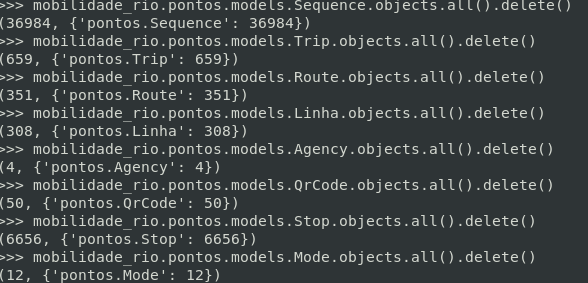

In [ ]:
python manage.py loaddata fixtures/qrcode.json
